In [1]:
import os
import sys
import json
import torch

sys.path.append("../")
from lib.utils import get_device, get_current_date
from lib.utils.constants import Subtask, Track, PreprocessTextLevel, DatasetType
from lib.utils.models import sequential_fully_connected
from lib.data.loading import load_train_dev_test_df
from lib.data.tokenizer import get_tokenizer
from lib.training.optimizer import get_optimizer, get_scheduler
from lib.training.loss import get_loss_fn
from lib.training.metric import get_metric

/Users/tmarchitan/Developer/ml_research/machine-generated_text_detection/.env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [63]:
CONFIG_FILE_PATH = os.path.relpath("../config.json")

config = {}
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = json.load(config_file)

DEVICE = get_device()
print(f"Using device: {DEVICE}")

Using device: mps


In [3]:
# config

In [64]:
task = None
if "task" in config:
    task = Subtask(config["task"])
else:
    raise ValueError("Task not specified in config")

track = None
if "track" in config:
    track = Track(config["track"])
else:
    print(f"Warning: Track not specified in config for subtask: {task}")

dataset_type = DatasetType.TransformerTruncationDataset
if "dataset_type" in config["data"]:
    dataset_type = DatasetType(config["data"]["dataset_type"])

dataset_type_settings = None
if "dataset_type_settings" in config["data"]:
    dataset_type_settings = config["data"]["dataset_type_settings"]

df_train, df_dev, df_test = load_train_dev_test_df(
    task=task,
    track=track,
    data_dir=f"../{config['data']['data_dir']}",
    label_column=config["data"]["label_column"],
    test_size=config["data"]["test_size"],
    preprocess_text_level=PreprocessTextLevel(
        config["data"]["preprocess_text_level"]
    ),
)

print(f"df_train.shape: {df_train.shape}")
print(f"df_dev.shape: {df_dev.shape}")
print(f"df_test.shape: {df_test.shape}")

Loading train data...
Train/dev split... (df_train.shape: (3649, 3))
Loading test data... ---> .././data/original_data/SubtaskC/SubtaskC_dev.jsonl
df_train.shape: (2919, 3)
df_dev.shape: (730, 3)
df_test.shape: (505, 3)


In [65]:
DEBUG = False
if DEBUG:
    results_dir = os.path.relpath("../runs/SubtaskC/")
else:
    results_dir = os.path.relpath(
        f"../runs/{get_current_date()}-{task.value}-{config['model']}"
    )
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

print(f"Will save results to: {results_dir}")

with open(results_dir + "/config.json", "w") as f:
    json.dump(config, f, indent=4)

Will save results to: ../runs/04-01-2024_19:05:37-SubtaskC-char_word_cnn-bilstm


# Load Word2Vec embeddings

In [6]:
df_train.head()

,id,text,label
2784,4a33ddc4-b755-42f3-8526-f0b4f1b3626c,This paper is the first (I believe) to establi...,89
2988,f232cb20-24d5-439c-9634-791d2cf51873,This manuscript tries to tackle neural network...,55
2718,c001a50d-de63-49e8-acb1-4665391f9381,This paper proposes an extension of the MAC me...,150
2223,09299ba2-0870-4fdc-91f8-ceb29dddb958,The paper proposes two methods for what is cal...,133
1284,fa7bc655-b107-4258-9c26-42b9bdb89e09,SUMMARY \r\nThis paper discusses how data from...,43


In [41]:
# WORD2VEC_MODEL_NAME = "word2vec-google-news-300"
# WORD2VEC_MODEL_NAME = "glove-wiki-gigaword-300"
WORD2VEC_MODEL_NAME = "fasttext-wiki-news-subwords-300"  # ~ 50% (train), 60% (dev), 64% (test) word coverage

In [42]:
import gensim.downloader as gensim_api

word2vec_model = gensim_api.load(WORD2VEC_MODEL_NAME)

In [43]:
# Count how many words from the dataset are in the word2vec model
from collections import Counter


def count_words_in_word2vec_model(df, word2vec_model):
    word_counts = Counter()
    for text in df["text"]:
        text = text.replace("\n", " ")
        text = text.replace("\t", " ")
        text = text.replace("\r", " ")

        words = [w for w in text.split(" ") if w != ""]

        word_counts.update(words)

    word2vec_words = set(word2vec_model.index_to_key)
    dataset_words = set(word_counts.keys())

    print(f"Number of words in the word2vec model: {len(word2vec_words)}")
    print(f"Number of words in the dataset: {len(dataset_words)}")

    common_words = word2vec_words.intersection(dataset_words)
    percentage = len(common_words) / len(dataset_words) * 100

    print(
        f"Number of words in the dataset that are in the word2vec model: {len(common_words)} ({percentage:.2f}%)"
    )

    return common_words

In [44]:
_ = count_words_in_word2vec_model(df_train, word2vec_model)
_ = count_words_in_word2vec_model(df_dev, word2vec_model)
_ = count_words_in_word2vec_model(df_test, word2vec_model)

Number of words in the word2vec model: 999999
Number of words in the dataset: 22625
Number of words in the dataset that are in the word2vec model: 11185 (49.44%)
Number of words in the word2vec model: 999999
Number of words in the dataset: 12553
Number of words in the dataset that are in the word2vec model: 7447 (59.32%)
Number of words in the word2vec model: 999999
Number of words in the dataset: 7873
Number of words in the dataset that are in the word2vec model: 5038 (63.99%)


In [45]:
print(type(word2vec_model))

<class 'gensim.models.keyedvectors.KeyedVectors'>


# Build vocabulary

In [66]:
import pandas as pd
from tqdm import tqdm


def text_cleanup(text):
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = text.replace("\r", " ")

    return text


def split_text_into_words(text):
    text = text_cleanup(text)

    words = [w for w in text.split(" ") if w != ""]

    return words


class CharacterVocabulary:
    unknown_token = "<UNK>"
    padding_token = "<PAD>"

    unknown_token_idx = 0
    padding_token_idx = 1

    def __init__(self):
        self.start_idx = 2
        self.char2idx = {
            CharacterVocabulary.unknown_token: CharacterVocabulary.unknown_token_idx,
            CharacterVocabulary.padding_token: CharacterVocabulary.padding_token_idx,
        }
        self.idx2char = {
            CharacterVocabulary.unknown_token_idx: CharacterVocabulary.unknown_token,
            CharacterVocabulary.padding_token_idx: CharacterVocabulary.padding_token,
        }

    def build_vocabulary(self, df: pd.DataFrame):
        idx = self.start_idx
        for text in tqdm(df["text"], desc="Building vocabulary"):
            text = text_cleanup(text)

            for c in text:
                if c in self.char2idx:
                    continue

                # character is not in char2idx
                self.char2idx[c] = idx
                self.idx2char[idx] = c

                idx += 1

    @property
    def vocab_size(self):
        return len(self.char2idx)


class WordVocabulary:
    unknown_token = "<UNK>"
    padding_token = "<PAD>"

    unknown_token_idx = 0
    padding_token_idx = 1

    def __init__(self):
        self.start_idx = 2
        self.word2idx = {
            WordVocabulary.unknown_token: WordVocabulary.unknown_token_idx,
            WordVocabulary.padding_token: WordVocabulary.padding_token_idx,
        }
        self.idx2word = {
            WordVocabulary.unknown_token_idx: WordVocabulary.unknown_token,
            WordVocabulary.padding_token_idx: WordVocabulary.padding_token,
        }

    def build_vocabulary(self, df: pd.DataFrame):
        idx = self.start_idx
        for text in tqdm(df["text"], desc="Building vocabulary"):
            words = split_text_into_words(text)

            for word in words:
                if word in self.word2idx:
                    continue

                # word is not in word2idx
                self.word2idx[word] = idx
                self.idx2word[idx] = word

                idx += 1

    @property
    def vocab_size(self):
        return len(self.word2idx)

In [67]:
char_vocabulary = CharacterVocabulary()
char_vocabulary.build_vocabulary(df_train)

word_vocabulary = WordVocabulary()
word_vocabulary.build_vocabulary(df_train)

Building vocabulary: 100%|██████████| 2919/2919 [00:00<00:00, 44462.43it/s]


In [68]:
print(f"Char vocabulary size: {char_vocabulary.vocab_size}")
print(f"Word vocabulary size: {word_vocabulary.vocab_size}")

Char vocabulary size: 140
Word vocabulary size: 22627


In [69]:
def get_unknown_characters(vocab, df):
    all_characters = set()
    unknown_characters = set()
    for text in tqdm(df["text"], desc="Counting unknown words"):
        text = text_cleanup(text)

        for c in text:
            all_characters.add(c)
            if c not in vocab.char2idx:
                unknown_characters.add(c)

    return all_characters, unknown_characters


def get_unknown_words(vocab, df):
    all_words = set()
    unknown_words = set()
    for text in tqdm(df["text"], desc="Counting unknown words"):
        words = split_text_into_words(text)

        for word in words:
            all_words.add(word)
            if word not in vocab.word2idx:
                unknown_words.add(word)

    return all_words, unknown_words

In [70]:
dev_all_chars, dev_unknown_chars = get_unknown_characters(char_vocabulary, df_dev)
print(f"Number of unknown chars in dev: {len(dev_unknown_chars)}/{len(dev_all_chars)} ({len(dev_unknown_chars) / len(dev_all_chars) * 100:.2f}%)")

test_all_chars, test_unknown_chars = get_unknown_characters(char_vocabulary, df_test)
print(f"Number of unknown chars in test: {len(test_unknown_chars)}/{len(test_all_chars)} ({len(test_unknown_chars) / len(test_all_chars) * 100:.2f}%)")

dev_all_words, dev_unknown_words = get_unknown_words(word_vocabulary, df_dev)
print(f"Number of unknown words in dev: {len(dev_unknown_words)}/{len(dev_all_words)} ({len(dev_unknown_words) / len(dev_all_words) * 100:.2f}%)")

test_all_words, test_unknown_words = get_unknown_words(word_vocabulary, df_test)
print(f"Number of unknown words in test: {len(test_unknown_words)}/{len(test_all_words)} ({len(test_unknown_words) / len(test_all_words) * 100:.2f}%)")

Counting unknown words: 100%|██████████| 730/730 [00:00<00:00, 23193.84it/s]


Number of unknown chars in dev: 3/111 (2.70%)


Counting unknown words: 100%|██████████| 505/505 [00:00<00:00, 24470.57it/s]


Number of unknown chars in test: 3/105 (2.86%)


Counting unknown words: 100%|██████████| 730/730 [00:00<00:00, 31667.57it/s]


Number of unknown words in dev: 2206/12553 (17.57%)


Counting unknown words: 100%|██████████| 505/505 [00:00<00:00, 36845.26it/s]

Number of unknown words in test: 2229/7873 (28.31%)


In [14]:
dev_unknown_chars

{'é', 'í', 'ó'}

In [16]:
test_unknown_chars

{'Π', 'ₓ', '\uf06e'}

In [82]:
# Method to count number of tokens in each text given a pandas dataframe
def count_tokens(df):
    return df.text.apply(lambda x: max([len(w) for w in split_text_into_words(x)]))

train_counts = count_tokens(df_train)
dev_counts = count_tokens(df_dev)
test_counts = count_tokens(df_test)

min_train_count = train_counts.min()
max_train_count = train_counts.max()
mean_train_count = train_counts.mean()

print(f"min_train_count: {min_train_count}")
print(f"max_train_count: {max_train_count}")
print(f"mean_train_count: {mean_train_count}")

min_dev_count = dev_counts.min()
max_dev_count = dev_counts.max()
mean_dev_count = dev_counts.mean()

print(f"min_dev_count: {min_dev_count}")
print(f"max_dev_count: {max_dev_count}")
print(f"mean_dev_count: {mean_dev_count}")

min_test_count = test_counts.min()
max_test_count = test_counts.max()
mean_test_count = test_counts.mean()

print(f"min_test_count: {min_test_count}")
print(f"max_test_count: {max_test_count}")
print(f"mean_test_count: {mean_test_count}")

min_train_count: 10
max_train_count: 72
mean_train_count: 16.410757108598837
min_dev_count: 11
max_dev_count: 44
mean_dev_count: 16.412328767123288
min_test_count: 12
max_test_count: 34
mean_test_count: 16.548514851485148


/var/folders/2x/2b9h25hj733f81_f7wn1krjh0000gp/T/ipykernel_89162/1025394776.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_counts, ax=ax, label="train")
/var/folders/2x/2b9h25hj733f81_f7wn1krjh0000gp/T/ipykernel_89162/1025394776.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dev

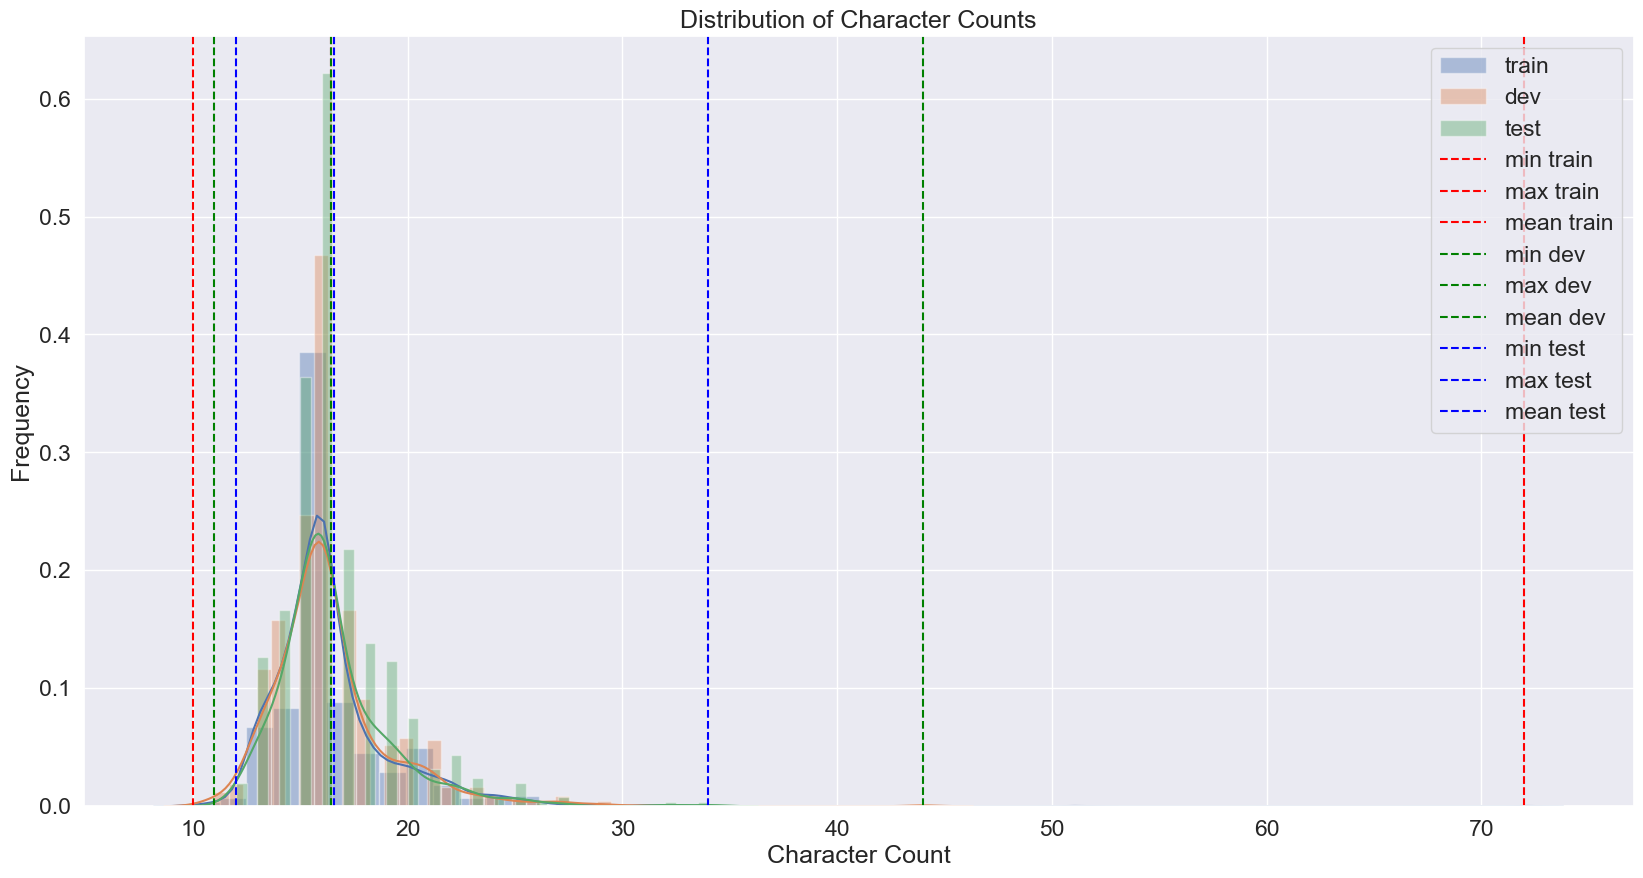

In [83]:
# Plot histogram of token counts for each dataset and point out the min, max, and mean
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")
sns.set(font_scale=1.5)

fig, ax = plt.subplots(figsize=(20, 10))
sns.distplot(train_counts, ax=ax, label="train")
sns.distplot(dev_counts, ax=ax, label="dev")
sns.distplot(test_counts, ax=ax, label="test")

ax.axvline(min_train_count, color="red", linestyle="--", label="min train")
ax.axvline(max_train_count, color="red", linestyle="--", label="max train")
ax.axvline(mean_train_count, color="red", linestyle="--", label="mean train")

ax.axvline(min_dev_count, color="green", linestyle="--", label="min dev")
ax.axvline(max_dev_count, color="green", linestyle="--", label="max dev")
ax.axvline(mean_dev_count, color="green", linestyle="--", label="mean dev")

ax.axvline(min_test_count, color="blue", linestyle="--", label="min test")  # long dash with offset
ax.axvline(max_test_count, color="blue", linestyle="--", label="max test")
ax.axvline(mean_test_count, color="blue", linestyle="--", label="mean test")

ax.set_xlabel("Character Count")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Character Counts")
ax.legend()

plt.savefig("../plots/characters_distribution.png")
plt.show()

# Build the dataset

In [71]:
import numpy as np
from torch.utils.data import Dataset


class TokenClassificationDataset(Dataset):
    def __init__(
        self,
        ids: np.ndarray,
        texts: np.ndarray,
        targets: np.ndarray | None,
        char_vocabulary: CharacterVocabulary,
        word_vocabulary: WordVocabulary,
        char_max_len: int,
        word_max_len: int,
        debug: bool = False,
    ):
        super().__init__()

        self.ids = ids
        self.texts = texts
        self.targets = targets
        self.char_vocab = char_vocabulary
        self.word_vocab = word_vocabulary
        self.char_max_len = char_max_len
        self.word_max_len = word_max_len
        self.debug = debug

    def __len__(self):
        return len(self.ids)
    
    def __getitem__(self, index):
        item_id = self.ids[index]
        text = self.texts[index]
        target = -1 if self.targets is None else self.targets[index]
        targets_available = False if target == -1 else True

        words = split_text_into_words(text)

        if self.debug:
            print(f"Text: {text}")
            print(f"Words: {words}")
            print(f"Machine text start position: {target}")
            print()

        targets = []
        corresponding_word = []
        tokens = []
        input_ids = []
        char_input_ids = []
        attention_mask = []
        char_attention_mask = []

        for idx, word in enumerate(words):
            word_encoded = [c for c in word]
            sub_words = len(word_encoded)

            if targets_available:
                is_machine_text = 1 if idx >= target else 0
                # targets.extend([is_machine_text] * sub_words)
                targets.append(is_machine_text)

            # corresponding_word.extend([idx] * sub_words)
            corresponding_word.append(idx)
            # tokens.extend(word_encoded)
            tokens.append(word)
            input_ids.append(
                self.word_vocab.word2idx.get(word, self.word_vocab.unknown_token_idx)
            )
            
            attention_mask.append(1)

            current_word_char_input_ids = [
                self.char_vocab.char2idx.get(c, self.char_vocab.unknown_token_idx)
                for c in word_encoded
            ]
            current_word_char_attention_mask = [1] * sub_words

            if len(current_word_char_input_ids) < self.char_max_len:
                current_word_char_input_ids = (
                    # [self.char_vocab.padding_token_idx]
                    current_word_char_input_ids
                    + [self.char_vocab.padding_token_idx] * (self.char_max_len - len(current_word_char_input_ids))
                )
                current_word_char_attention_mask = (
                    # [1]
                    current_word_char_attention_mask
                    + [0] * (self.char_max_len - len(current_word_char_attention_mask))
                )
            else:
                current_word_char_input_ids = current_word_char_input_ids[: self.char_max_len]
                current_word_char_attention_mask = current_word_char_attention_mask[: self.char_max_len]

            char_input_ids.append(current_word_char_input_ids)
            char_attention_mask.append(current_word_char_attention_mask)

            if self.debug:
                print(
                    f"word[{idx}]:\n"
                    f"{'':-<5}> tokens: {[word]}\n"
                    f"{'':-<5}> corresponding_word: {corresponding_word[-1]}\n"
                    f"{'':-<5}> input_ids: {input_ids[-1]}\n"
                    f"{'':-<5}> char_input_ids: {char_input_ids[-sub_words:]}\n"
                    f"{'':-<5}> is_machine_text: {is_machine_text}"
                )

        if self.debug:
            print()

            print(f"corresponding_word: {corresponding_word}")
            print(f"tokens: {tokens}")
            print(f"input_ids: {input_ids}")
            print(f"char_input_ids: {char_input_ids}")
            print(f"attention_mask: {attention_mask}")
            print(f"char_attention_mask: {char_attention_mask}")

            print()

            print(f"Machine text start word: {words[targets.index(1)]}")
            print(f"True machine text start word: {words[target]}")

            print()

        if len(input_ids) < self.word_max_len:
            if targets_available:
                targets = (
                    targets
                    + [-100] * (self.word_max_len - len(input_ids))
                )

            corresponding_word = (
                # [-100]
                corresponding_word
                + [-100] * (self.word_max_len - len(input_ids))
            )
            tokens = (
                # [self.tokenizer.bos_token]
                tokens
                # + [self.tokenizer.eos_token]
                + [self.word_vocab.padding_token] * (self.word_max_len - len(tokens))
            )
            input_ids = (
                # [self.tokenizer.bos_token_id]
                input_ids
                # + [self.tokenizer.eos_token_id]
                + [self.word_vocab.padding_token_idx] * (self.word_max_len - len(input_ids))
            )
            attention_mask = (
                # [1]
                attention_mask
                + [0] * (self.word_max_len - len(attention_mask))
            )
            char_input_ids = (
                char_input_ids
                + [[self.char_vocab.padding_token_idx] * self.char_max_len] * (self.word_max_len - len(char_input_ids))
            )
            char_attention_mask = (
                char_attention_mask
                + [[0] * self.char_max_len] * (self.word_max_len - len(char_attention_mask))
            )
        else:
            if targets_available:
                targets = targets[: self.word_max_len]

            corresponding_word = corresponding_word[: self.word_max_len]
            # corresponding_word = (
            #     [-100]
            #     + corresponding_word[: self.max_len - 2]
            #     + [-100]
            # )
            tokens = tokens[: self.word_max_len]
            # tokens = (
            #     [self.tokenizer.bos_token]
            #     + tokens[: self.max_len - 2]
            #     + [self.tokenizer.eos_token]
            # )
            input_ids = input_ids[: self.word_max_len]
            # input_ids = (
            #     [self.tokenizer.bos_token_id]
            #     + input_ids[: self.max_len - 2]
            #     + [self.tokenizer.eos_token_id]
            # )
            attention_mask = attention_mask[: self.word_max_len]
            # attention_mask = (
            #     [1]
            #     + attention_mask[: self.max_len - 2]
            #     + [1]
            # )
            char_input_ids = char_input_ids[: self.word_max_len]
            char_attention_mask = char_attention_mask[: self.word_max_len]

        encoded = {}
        encoded["id"] = item_id
        encoded["text"] = text
        encoded["true_target"] = torch.tensor(target)
        encoded["corresponding_word"] = torch.tensor(corresponding_word)
        encoded["input_ids"] = torch.tensor(input_ids)
        encoded["char_input_ids"] = torch.tensor(char_input_ids)
        encoded["attention_mask"] = torch.tensor(attention_mask)
        encoded["char_attention_mask"] = torch.tensor(char_attention_mask)
        if targets_available:
            encoded["target"] = torch.tensor(targets)

        if self.debug:
            print(f"Tokenized human position: {targets.index(1)}")
            print(f"Original human position: {target}")
            print(f"Full human text: {text}\n\n")
            print(f"Human truncated text: {[w for w in text.split(' ')[:target] if w != '']}\n\n")

            encoded["partial_human_review"] = " ".join(
                [w for w in text.split(' ')[:target] if w != '']
            )

        return encoded

In [72]:
from torch.utils.data import DataLoader

# tokenizer = get_tokenizer(**config["tokenizer"])

# char_max_len = 25
train_dataset = TokenClassificationDataset(
    ids=df_train["id"].values,
    texts=df_train["text"].values,
    targets=df_train["label"].values,
    char_vocabulary=char_vocabulary,
    word_vocabulary=word_vocabulary,
    char_max_len=config["data"]["char_max_len"],
    word_max_len=config["data"]["max_len"],
    debug=False,
)
dev_dataset = TokenClassificationDataset(
    ids=df_dev["id"].values,
    texts=df_dev["text"].values,
    targets=df_dev["label"].values,
    char_vocabulary=char_vocabulary,
    word_vocabulary=word_vocabulary,
    char_max_len=config["data"]["char_max_len"],
    word_max_len=config["data"]["max_len"],
    debug=False,
)
test_dataset = TokenClassificationDataset(
    ids=df_test["id"].values,
    texts=df_test["text"].values,
    targets=df_test["label"].values,
    char_vocabulary=char_vocabulary,
    word_vocabulary=word_vocabulary,
    char_max_len=config["data"]["char_max_len"],
    word_max_len=config["data"]["max_len"],
    debug=False,
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=config["data"]["batch_size"],
    shuffle=True,
)
dev_dataloader = DataLoader(
    dev_dataset,
    batch_size=config["data"]["batch_size"],
    shuffle=False,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=config["data"]["batch_size"],
    shuffle=False,
)

In [16]:
char_vocabulary.idx2char[3]

'h'

In [40]:
word_vocabulary.idx2word[3]

'paper'

In [73]:
for i, batch in enumerate(train_dataloader):
    print(f"Batch=[{i + 1}/{len(train_dataloader)}]")
    print(f"batch['input_ids'].shape: {batch['input_ids'].shape}")
    print(f"batch['char_input_ids'].shape: {batch['char_input_ids'].shape}")
    print(f"batch['attention_mask'].shape: {batch['attention_mask'].shape}")
    print(f"batch['char_attention_mask'].shape: {batch['char_attention_mask'].shape}")
    print(f"batch['target'].shape: {batch['target'].shape}")
    print(f"batch['target']: {batch['target']}")
    print(f"batch['corresponding_word']: {batch['corresponding_word']}")
    break

# for i, batch in enumerate(dev_dataloader):
#     print(f"Batch=[{i + 1}/{len(dev_dataloader)}]")
# #     # break

Batch=[1/183]
batch['input_ids'].shape: torch.Size([16, 1024])
batch['char_input_ids'].shape: torch.Size([16, 1024, 25])
batch['attention_mask'].shape: torch.Size([16, 1024])
batch['char_attention_mask'].shape: torch.Size([16, 1024, 25])
batch['target'].shape: torch.Size([16, 1024])
batch['target']: tensor([[   0,    0,    0,  ..., -100, -100, -100],
        [   0,    0,    0,  ..., -100, -100, -100],
        [   0,    0,    0,  ..., -100, -100, -100],
        ...,
        [   0,    0,    0,  ..., -100, -100, -100],
        [   1,    1,    1,  ..., -100, -100, -100],
        [   0,    0,    0,  ..., -100, -100, -100]])
batch['corresponding_word']: tensor([[   0,    1,    2,  ..., -100, -100, -100],
        [   0,    1,    2,  ..., -100, -100, -100],
        [   0,    1,    2,  ..., -100, -100, -100],
        ...,
        [   0,    1,    2,  ..., -100, -100, -100],
        [   0,    1,    2,  ..., -100, -100, -100],
        [   0,    1,    2,  ..., -100, -100, -100]])


In [11]:
# vocabulary

# Create Char CNN feature extraction with model for token classification

In [86]:
import torch.nn as nn
from transformers import LongformerModel


class CharacterLevelCNNEmbedding(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        kernel_size,
        max_len,
        out_size,
    ):
        super().__init__()

        self.vocab_size = vocab_size
        self.max_len = max_len
        self._output_dim = None

        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embedding_dim,
            padding_idx=1,
        )

        # self.convs = nn.ModuleList(
        #     [
        #         nn.Sequential(
        #             nn.Conv1d(
        #                 in_channels=embedding_dim,
        #                 out_channels=num_filters,
        #                 kernel_size=kernel_size,
        #             ),
        #             nn.MaxPool1d(kernel_size=kernel_size),
        #         )
        #         for kernel_size in kernel_sizes
        #     ]
        # )

        self.conv = nn.Conv1d(
            in_channels=embedding_dim,
            out_channels=out_size,
            kernel_size=kernel_size,
        )

        self.max_pool = nn.MaxPool1d(kernel_size=kernel_size)

        self._init_embedding_weights()
        self._compute_output_dim()

    @property
    def output_dim(self):
        return self._output_dim

    def forward(self, input_ids, attention_mask, labels=None):
        # input_ids: (batch_size, max_seq_len, max_char_len)
        # print(f"input_ids.shape: {input_ids.shape}")

        outputs = []
        for i in range(input_ids.shape[0]):
            # batch_output = []
            # input_ids[i] shape: (max_seq_len, max_char_len)
            # TODO: We can consider batch_size = max_seq_len
            # And pass it throyugh the embedding layer stuff
            
            batch_output = self.embedding(input_ids[i])
            # print(f"batch_output.shape: {batch_output.shape}")

            batch_output = batch_output.permute(0, 2, 1)
            # print(f"batch_output.shape: {batch_output.shape}")

            batch_output = self.conv(batch_output)
            # print(f"batch_output.shape: {batch_output.shape}")

            batch_output = self.max_pool(batch_output)
            # print(f"batch_output.shape: {batch_output.shape}")

            batch_output = batch_output.reshape(batch_output.shape[0], -1)
            # print(f"batch_output.shape: {batch_output.shape}")

            # for word in input_ids[i]:
            #     # word: (max_char_len)
            #     # print(f"word.shape: {word.shape}")

            #     # word.unsqueeze(0): (1, max_char_len)
            #     word = word.unsqueeze(0)
            #     # print(f"word.unsqueeze(0).shape: {word.shape}")

            #     output = self.embedding(word)
            #     # print(f"emb_out = output.shape: {output.shape}")

            #     output = output.permute(0, 2, 1)
            #     # print(f"permute_out = output.shape: {output.shape}")

            #     output = self.conv(output)
            #     # print(f"conv_out = output.shape: {output.shape}")

            #     output = self.max_pool(output)
            #     # print(f"max_pool_out = output.shape: {output.shape}")

            #     output = output.squeeze(0).reshape(-1)

            #     # output.shape: (self.output_dim)

            #     # print(f"out = output.shape: {output.shape}")

            #     batch_output.append(output)

            # batch_output = torch.stack(batch_output)
            # print(f"batch_output.shape: {batch_output.shape}")
            outputs.append(batch_output)

        # output = self.embedding(input_ids)
        # # print(f"output.shape: {output.shape}")

        # output = output.permute(0, 2, 1)
        # # print(f"output.shape: {output.shape}")

        # output = self.conv(output)
        # # print(f"output.shape: {output.shape}")

        # output = self.max_pool(output)
        # # print(f"output.shape: {output.shape}")
        
        # print(len(outputs))
        outputs = torch.stack(outputs)
        # print(f"outputs_out = outputs.shape: {outputs.shape}")

        # output.shape: (batch_size, max_seq_len, self.output_dim)

        return outputs

    def _init_embedding_weights(self):
        self.embedding.weight.data = self.embedding.weight.data.uniform_(
            -0.5, 0.5
        )

    def _compute_output_dim(self):
        x = torch.randint(low=0, high=self.vocab_size, size=(1, self.max_len))

        output = self.embedding(x)
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.max_pool(output)

        # flatten
        output = output.reshape(1, -1)

        self._output_dim = output.shape[1]

    @property
    def output_dim(self):
        return self._output_dim


class CharacterAndWordLevelEmbeddingsWithBiLSTMForTokenClassification(nn.Module):
    def __init__(
        self,
        char_vocab_size,
        char_embedding_dim,
        char_kernel_size,
        char_max_len,
        char_out_size,
        word_vocab_size,
        word_embedding_dim,
        out_size,
        dropout_p=0.3,
        n_layers=1,
        hidden_dim=32,
        fc=[],
    ):
        super().__init__()

        self.out_size = out_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        self.character_embeddings = CharacterLevelCNNEmbedding(
            vocab_size=char_vocab_size,
            embedding_dim=char_embedding_dim,
            kernel_size=char_kernel_size,
            max_len=char_max_len,
            out_size=char_out_size,
        )

        self.word_embeddings = nn.Embedding(
            num_embeddings=word_vocab_size,
            embedding_dim=word_embedding_dim,
            padding_idx=1,
        )

        self.lstm = nn.LSTM(
            self.character_embeddings.output_dim + word_embedding_dim,
            hidden_dim,
            n_layers,
            bidirectional=True,
            batch_first=True,
        )

        self.dropout = nn.Dropout(p=dropout_p)
        self.classifier = sequential_fully_connected(
            2 * hidden_dim, out_size, fc, dropout_p
        )

    def forward(
        self,
        input_ids,
        attention_mask,
        char_input_ids,
        char_attention_mask,
        device,
        labels=None
    ):
        # input_ids: (batch_size, max_seq_len)
        # print(f"input_ids.shape: {input_ids.shape}")

        # char_embeddings: (batch_size, max_seq_len, self.character_embeddings.output_dim)
        char_embeddings = self.character_embeddings(
            char_input_ids, char_attention_mask,
        )
        # print(f"char_embeddings.shape: {char_embeddings.shape}")

        # word_embeddings: (batch_size, max_seq_len, word_embedding_dim)
        word_embeddings = self.word_embeddings(input_ids)
        # print(f"word_embeddings.shape: {word_embeddings.shape}")

        # embeddings: (batch_size, max_seq_len, self.character_embeddings.output_dim + word_embedding_dim)
        embeddings = torch.cat([char_embeddings, word_embeddings], dim=2)
        # print(f"embeddings.shape: {embeddings.shape}")

        # print(f"attention_mask.shape: {attention_mask.shape}")

        # lengths: (batch_size)
        lengths = attention_mask.sum(dim=1)
        # print(f"lengths.shape: {lengths.shape}")
        # print(f"lengths: {lengths}")

        packed_embeddings = nn.utils.rnn.pack_padded_sequence(
            embeddings, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        # print(f"packed_embeddings.data.shape: {packed_embeddings.data.shape}")

        packed_output, (_, _) = self.lstm(packed_embeddings)
        # print(f"packed_output.data.shape: {packed_output.data.shape}")

        output, _ = nn.utils.rnn.pad_packed_sequence(
            packed_output, batch_first=True, total_length=embeddings.shape[1],
        )
        # print(f"output.shape: {output.shape}")

        output = self.dropout(output)
        logits = self.classifier(output)

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss().to(device)
            loss = loss_fn(logits.view(-1, self.out_size), labels.view(-1))

        return loss, logits

    def freeze_transformer_layer(self):
        pass

    def unfreeze_transformer_layer(self):
        pass

    def get_predictions_from_logits(self, logits, labels=None, corresponding_word=None):
        # batch_size = logits.shape[0]

        # logits: (batch_size, max_seq_len, out_size)
        # labels: (batch_size, max_seq_len)
        # corresponding_word: (batch_size, max_seq_len)

        # print(f"logits.shape: {logits.shape}")
        # print(f"logits: {logits}")

        # preds: (batch_size, max_seq_len)
        preds = torch.argmax(logits, dim=-1)

        # print(f"preds.shape: {preds.shape}")
        # print(f"preds: {preds}")

        if labels is not None:
            # print(f"labels.shape: {labels.shape}")
            # print(f"labels: {labels}")

            # Keep only predictions where labels are not -100
            # clean_preds = preds[labels != -100].reshape(batch_size, -1)
            # clean_labels = labels[labels != -100].reshape(batch_size, -1)

            # print(f"clean_preds.shape: {clean_preds.shape}")
            # print(f"clean_preds: {clean_preds}")

            # print(f"clean_labels.shape: {clean_labels.shape}")
            # print(f"clean_labels: {clean_labels}")

            # Get the index of the first machine text word
            # predicted_positions = clean_preds.argmax(dim=-1)
            # true_positions = clean_labels.argmax(dim=-1)

            predicted_positions = []
            true_positions = []
            for p, l in zip(preds, labels):
                mask = l != -100

                clean_pred = p[mask]
                clean_label = l[mask]

                # print(f"clean_pred.shape: {clean_pred.shape}")
                # print(f"clean_pred: {clean_pred}")
                # print(f"clean_label.shape: {clean_label.shape}")
                # print(f"clean_label: {clean_label}")

                predicted_position = clean_pred.argmax(dim=-1)
                true_position = clean_label.argmax(dim=-1)

                # print(f"predicted_position: {predicted_position}")
                # print(f"true_position: {true_position}")

                predicted_positions.append(predicted_position.item())
                true_positions.append(true_position.item())

            # print(f"predicted_positions.shape: {predicted_positions.shape}")
            # print(f"predicted_positions: {predicted_positions}")

            # print(f"true_positions.shape: {true_positions.shape}")
            # print(f"true_positions: {true_positions}")

            # print(f"predicted_positions type: {type(predicted_positions)}")
            # print(f"true_positions type: {type(true_positions)}")

            return torch.Tensor(predicted_positions), torch.Tensor(true_positions)
        elif corresponding_word is not None:
            # print(f"corresponding_word.shape: {corresponding_word.shape}")
            # print(f"corresponding_word: {corresponding_word}")

            # Keep only predictions where corresponding_word are not -100
            # clean_preds = preds[corresponding_word != -100].reshape(
            #     batch_size, -1
            # ).detach().cpu().numpy()
            # clean_corresponding_word = corresponding_word[corresponding_word != -100].reshape(
            #     batch_size, -1
            # ).detach().cpu().numpy()

            # print(f"clean_preds.shape: {clean_preds.shape}")
            # print(f"clean_preds: {clean_preds}")

            # print(f"clean_corresponding_word.shape: {clean_corresponding_word.shape}")
            # print(f"clean_corresponding_word: {clean_corresponding_word}")

            predicted_positions = []
            for p, w in zip(preds, corresponding_word):
                mask = w != -100

                clean_pred = p[mask]
                clean_corresponding_word = w[mask]

                # print(f"clean_pred.shape: {clean_pred.shape}")
                # print(f"clean_pred: {clean_pred}")
                # print(f"clean_corresponding_word.shape: {clean_corresponding_word.shape}")
                # print(f"clean_corresponding_word: {clean_corresponding_word}")

                # Get the index of the first machine text word
                index = torch.where(clean_pred == 1)[0]
                value = index[0] if index.size else len(clean_pred) - 1
                position = clean_corresponding_word[value]

                # print(f"index: {index}")
                # print(f"value: {value}")
                # print(f"position: {position}")

                predicted_positions.append(position.item())
            #     # pred = pred.detach().cpu().numpy()

            #     index = np.where(pred == 1)[0]
            #     value = index[0] if index.size else len(pred) - 1
            #     position = clean_corresponding_word[idx][value]

            #     predicted_positions.append(position.item())

            # print(f"predicted_positions: {predicted_positions}")

            return predicted_positions, None
        else:
            raise ValueError("Either labels or corresponding_word must be provided")

    def _init_embedding_weights(self):
        self.word_embeddings.weight.data = self.word_embeddings.weight.data.uniform_(
            -0.5, 0.5
        )

# Train model

In [87]:
import pandas as pd
from tqdm import tqdm
# from time import time
from collections import defaultdict


def train_epoch(
    model,
    dataloader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    metric_fn,
    print_freq=10,
):
    model.train()

    losses = []

    all_predictions = []
    all_true = []
    all_ids = []

    for i, batch in enumerate(dataloader):
        ids = batch["id"]
        input_ids = batch["input_ids"].to(device)
        char_input_ids = batch["char_input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        char_attention_mask = batch["char_attention_mask"].to(device)
        targets = batch["target"].to(device)
        corresponding_word = batch["corresponding_word"].to(device)

        loss, logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            char_input_ids=char_input_ids,
            char_attention_mask=char_attention_mask,
            device=device,
            labels=targets,
        )

        predictions, true_predictions = model.get_predictions_from_logits(
            logits=logits,
            labels=targets,
            corresponding_word=corresponding_word
        )

        # print(f"predictions: {predictions}")
        # print(f"true_predictions: {true_predictions}")

        losses.append(loss.item())

        all_predictions.extend(predictions.tolist())
        all_true.extend(true_predictions.tolist())
        all_ids.extend(ids)

        if i % print_freq == 0:
            print(
                f"Batch [{i + 1}/{len(dataloader)}]; "
                f"Loss: {loss.item():.5f}; "
                f"Mean absolute error: {metric_fn(true_predictions, predictions):.5f}"
            )

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        if scheduler is not None:
            scheduler.step()
        optimizer.zero_grad()

    return np.mean(losses), (all_ids, all_true, all_predictions)


def validation_epoch(
    model,
    dataloader,
    loss_fn,
    device,
    metric_fn,
):
    model.eval()

    losses = []
    all_predictions = []
    all_true = []
    all_ids = []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            ids = batch["id"]
            input_ids = batch["input_ids"].to(device)
            char_input_ids = batch["char_input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            char_attention_mask = batch["char_attention_mask"].to(device)
            targets = batch["target"].to(device)
            corresponding_word = batch["corresponding_word"].to(device)

            loss, logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                char_input_ids=char_input_ids,
                char_attention_mask=char_attention_mask,
                device=device,
                labels=targets,
            )

            predictions, true_predictions = model.get_predictions_from_logits(
                logits=logits,
                labels=targets,
                corresponding_word=corresponding_word
            )

            losses.append(loss.item())

            all_predictions.extend(predictions.tolist())
            all_true.extend(true_predictions.tolist())
            all_ids.extend(ids)

    return np.mean(losses), (all_ids, all_true, all_predictions)


def training_loop(
    model,
    num_epochs,
    train_dataloader,
    dev_dataloader,
    loss_fn,
    optimizer_config,
    scheduler_config,
    device,
    metric_fn,
    is_better_metric_fn,
    num_epochs_before_finetune,
    results_dir,
):
    history = defaultdict(list)
    best_metric = None
    best_model_state = None

    optimizer = get_optimizer(model, optimizer_config, finetune=False)
    scheduler = None

    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}/{num_epochs}")
        if epoch <= num_epochs_before_finetune:
            print("Freeze transformer")
        else:
            print("Finetune transformer")
        print("-" * 10)

        if epoch == num_epochs_before_finetune + 1:
            model.unfreeze_transformer_layer()
            optimizer = get_optimizer(model, optimizer_config, finetune=True)
            scheduler = get_scheduler(
                optimizer,
                num_training_steps=len(train_dataloader) * num_epochs,
                **scheduler_config,
            )

        train_loss, (train_ids, train_true, train_predict) = train_epoch(
            model,
            train_dataloader,
            loss_fn,
            optimizer,
            device,
            scheduler,
            metric_fn,
        )

        train_metric = metric_fn(train_true, train_predict)

        print(f"Train Loss: {train_loss:.5f}; Train Metric: {train_metric:.5f}")

        dev_loss, (dev_ids, dev_true, dev_predict) = validation_epoch(
            model,
            dev_dataloader,
            loss_fn,
            device,
            metric_fn,
        )

        dev_metric = metric_fn(dev_true, dev_predict)

        print(
            f"Validation Loss: {dev_loss:.5f}; "
            f"Validation Metric: {dev_metric:.5f}"
        )

        history["train_metric"].append(train_metric)
        history["train_loss"].append(train_loss)
        history["dev_metric"].append(dev_metric)
        history["dev_loss"].append(dev_loss)

        if best_metric is None or is_better_metric_fn(train_metric, best_metric):
            best_metric = train_metric
            best_model_state = model.state_dict()
            
            if results_dir is not None:
                torch.save(
                    best_model_state,
                    os.path.join(results_dir, "best_model.bin"),
                )

                df_train_predictions = pd.DataFrame(
                    {
                        "id": train_ids,
                        "true": train_true,
                        "predict": train_predict,
                    }
                )
                df_train_predictions.to_csv(
                    os.path.join(results_dir, "best_model_train_predict.csv"),
                    index=False
                )

                df_dev_predictions = pd.DataFrame(
                    {
                        "id": dev_ids,
                        "true": dev_true,
                        "predict": dev_predict,
                    }
                )
                df_dev_predictions.to_csv(
                    os.path.join(results_dir, "best_model_dev_predict.csv"),
                    index=False
                )

    df_history = pd.DataFrame(history)
    if results_dir is not None:
        df_history.to_csv(os.path.join(results_dir, "history.csv"), index=False)

        model.load_state_dict(torch.load(os.path.join(results_dir, "best_model.bin")))
    else:
        model.load_state_dict(best_model_state)

    return model, df_history

In [88]:
import torch

torch.cuda.empty_cache()

In [77]:
config["model_config"]["char_vocab_size"] = char_vocabulary.vocab_size
config["model_config"]["char_max_len"] = config["data"]["char_max_len"]
config["model_config"]["word_vocab_size"] = word_vocabulary.vocab_size

In [78]:
with open(results_dir + "/config.json", "w") as f:
    json.dump(config, f, indent=4)

In [89]:
num_epochs = config["training"]["num_epochs"]
model = CharacterAndWordLevelEmbeddingsWithBiLSTMForTokenClassification(
    **config["model_config"]
).to(DEVICE)
loss_fn = get_loss_fn(config["training"]["loss"], DEVICE)
optimizer_config = config["training"]["optimizer"]
scheduler_config = config["training"]["scheduler"]
metric_fn, is_better_metric_fn = get_metric(config["training"]["metric"])
num_epochs_before_finetune = config["training"]["num_epochs_before_finetune"]

best_model, df_history = training_loop(
    model,
    num_epochs,
    train_dataloader,
    dev_dataloader,
    loss_fn,
    optimizer_config,
    scheduler_config,
    DEVICE,
    metric_fn,
    is_better_metric_fn,
    num_epochs_before_finetune,
    results_dir,
)

Epoch 1/1
Freeze transformer
----------
Batch [1/183]; Loss: 0.15987; Mean absolute error: 56.87500
Batch [11/183]; Loss: 0.14823; Mean absolute error: 67.62500


KeyboardInterrupt: 

# Make predictions

In [80]:
import pandas as pd


def make_predictions(
    model,
    dataloader,
    device,
    results_dir,
    label_column,
    file_format="csv",
):
    model.eval()

    all_predictions = []
    all_true = []
    all_ids = []

    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader)):
            ids = batch["id"]
            input_ids = batch["input_ids"].to(device)
            char_input_ids = batch["char_input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            char_attention_mask = batch["char_attention_mask"].to(device)
            targets = batch["target"].to(device)
            corresponding_word = batch["corresponding_word"].to(device)

            _, logits = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                char_input_ids=char_input_ids,
                char_attention_mask=char_attention_mask,
                device=device,
                labels=targets,
            )

            predictions, true_predictions = model.get_predictions_from_logits(
                logits=logits,
                labels=targets,
                corresponding_word=corresponding_word
            )

            all_predictions.extend(predictions.tolist())
            all_true.extend(true_predictions.tolist())
            all_ids.extend(ids)

    df_predictions = pd.DataFrame(
        {
            "id": all_ids,
            "true": all_true,
            label_column: all_predictions,
        }
    )

    if results_dir is not None:
        if file_format == "csv":
            df_predictions.to_csv(
                os.path.join(results_dir, "submission.csv"),
                index=False,
            )
        elif file_format == "jsonl":
            df_predictions.to_json(
                os.path.join(results_dir, "submission.jsonl"),
                orient="records",
                lines=True,
            )
        else:
            raise ValueError(f"Unknown file format: {file_format}")
    else:
        print("Missing results_dir, not saving predictions to file!")

    return df_predictions

In [81]:
predictions = make_predictions(
    best_model,
    test_dataloader,
    DEVICE,
    results_dir,
    config["data"]["label_column"],
    file_format="csv",
)

100%|██████████| 32/32 [02:13<00:00,  4.17s/it]


In [82]:
!python ../scores_and_plots.py --results-dir "../runs/30-12-2023_20:25:57-SubtaskC-bilstm_for_token_classification"

Results on validation
MAE: 16.70274
--------------------
Results on test
MAE: 18.14851
--------------------
